# Import required libraties

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from sklearn.linear_model import LinearRegression
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Load dataset

In [2]:
# Load dataset
file_path = r'C:\Users\hp\project\all_upwork_jobs_2024-02-07-2024-03-24.csv'
df = pd.read_csv(file_path)

# Display basic information
print(df.head())
print(df.info())

                                               title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   

                                                link  \
0  https://www.upwork.com/jobs/Experienced-Media-...   
1  https://www.upwork.com/jobs/Full-Stack-Develop...   
2  https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3  https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4  https://www.upwork.com/jobs/Data-Engineer_%7E0...   

              published_date  is_hourly  hourly_low  hourly_high  budget  \
0  2024-02-17 09:09:54+00:00      False         NaN          NaN   500.0   
1  2024-02-17 09:09:17+00:00      False         NaN          NaN  1100.0   
2  2024-02-17 09:08:46+00:00       True        10.0         30.0     NaN   
3  2024-02-17 09:08:08

In [3]:
# Check Null Values
df.isnull().sum()

title                  1
link                   1
published_date         0
is_hourly              0
hourly_low        142406
hourly_high       146053
budget            140937
country             5077
dtype: int64

# Data Preprocessing

In [4]:
# Handling missing values in the DataFrame

# Replace missing hourly values with the median
df['hourly_low'].fillna(value=df['hourly_low'].median(), inplace=True)
df['hourly_high'].fillna(value=df['hourly_high'].median(), inplace=True)

# Calculate the budget for hourly jobs using the average of `hourly_low` and `hourly_high`
df.loc[df['is_hourly'], 'budget'] = (df['hourly_low'] + df['hourly_high']) / 2

# Fill missing country values with 'Unknown'
df['country'].fillna('Unknown', inplace=True)

# Display the result after handling missing values
print(df[['hourly_low', 'hourly_high', 'budget', 'country']].head())

   hourly_low  hourly_high  budget        country
0        15.0         30.0   500.0        Unknown
1        15.0         30.0  1100.0  United States
2        10.0         30.0    20.0  United States
3        15.0         30.0    22.5  United States
4        15.0         30.0   650.0          India


In [5]:
# Now drop if still any missing value is present
df.dropna(inplace=True)

In [6]:
df.isnull().sum()

title             0
link              0
published_date    0
is_hourly         0
hourly_low        0
hourly_high       0
budget            0
country           0
dtype: int64

In [7]:
df.shape

(244827, 8)

In [8]:
# Define a class for job title processing
class JobTitleCleaner:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        text = self._to_lowercase(text)
        text = self._remove_special_characters(text)
        text = self._remove_extra_whitespace(text)
        return self._filter_stopwords(text)

    def _to_lowercase(self, text):
        return text.lower()

    def _remove_special_characters(self, text):
        return re.sub(r'[^a-z\s]', '', text)

    def _remove_extra_whitespace(self, text):
        return re.sub(r'\s+', ' ', text).strip()

    def _filter_stopwords(self, text):
        words = word_tokenize(text)
        filtered_words = [word for word in words if word not in self.stop_words]
        return ' '.join(filtered_words)

# Instantiate the cleaner
cleaner = JobTitleCleaner()

# Apply the cleaning function to the 'title' column
df['Cleaned Job Title'] = df['title'].apply(cleaner.clean_text)

# Display the cleaned job titles
print(df[['title', 'Cleaned Job Title']].head())

                                               title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   

                                   Cleaned Job Title  
0  experienced media buyer solar pannel roofing i...  
1                               full stack developer  
2                                    smma bubble app  
3                talent hunter specialized marketing  
4                                      data engineer  


In [9]:
# Tokenize job titles and count keyword frequencies
from collections import Counter

# Split the cleaned job titles into individual keywords and flatten the list
keywords = df['Cleaned Job Title'].str.split().explode()

# Count the frequency of each keyword
keyword_counts = Counter(keywords)

# Retrieve the 30 most common keywords
top_keywords = keyword_counts.most_common(30)

# Output the top keywords
print("Top Keywords:", top_keywords)

Top Keywords: [('needed', 17571), ('website', 16688), ('developer', 15678), ('expert', 14910), ('video', 13822), ('design', 12984), ('designer', 12603), ('need', 10223), ('amp', 9276), ('specialist', 8939), ('looking', 8730), ('marketing', 8250), ('media', 8211), ('app', 8094), ('editor', 7758), ('youtube', 7585), ('social', 7554), ('data', 7036), ('create', 6836), ('content', 6723), ('manager', 6669), ('google', 6632), ('wordpress', 6595), ('assistant', 6490), ('web', 6462), ('business', 6100), ('project', 6066), ('development', 5899), ('logo', 5629), ('ads', 5378)]


In [10]:

# Initialize the TF-IDF Vectorizer with a limit on the number of features
vectorizer = TfidfVectorizer(max_features=100)

# Fit and transform the cleaned job titles to create the TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(df['Cleaned Job Title'])

# Convert the TF-IDF matrix to a DataFrame for easier manipulation
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate the sum of TF-IDF scores for each keyword and sort them in descending order
tfidf_scores = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Display the top 15 keywords based on their TF-IDF scores
print("Top TF-IDF Keywords:\n", tfidf_scores.head(15))

Top TF-IDF Keywords:
 website       9772.837588
needed        9444.632479
developer     9281.090132
expert        8639.339049
design        8245.233054
video         7653.085025
designer      7598.466970
need          6453.582390
specialist    5483.635873
looking       5325.399726
amp           5070.298583
app           4962.727481
marketing     4697.204410
editor        4559.897254
data          4480.035515
dtype: float64


# Job Title Keywords vs. Salaries

In [11]:
# Initialize dictionaries to store average salary and example URLs for each keyword
keyword_salary = {}
keyword_urls = {}

# Iterate through each keyword in the TF-IDF scores
for keyword in tfidf_scores.index:
    # Filter relevant jobs that contain the keyword in the cleaned job title
    relevant_jobs = df[df['Cleaned Job Title'].str.contains(keyword, na=False)]
    
    # Calculate the average salary for the relevant jobs
    keyword_salary[keyword] = relevant_jobs['budget'].mean()
    
    # Store the top 3 URLs for the relevant jobs
    keyword_urls[keyword] = relevant_jobs['link'].head(3).tolist()

# Create a DataFrame for better visualization of the keyword-salary mapping
keyword_salary_df = pd.DataFrame({
    'Keyword': list(keyword_salary.keys()),
    'Average Salary': list(keyword_salary.values()),
    'Example URLs': [', '.join(urls) for urls in keyword_urls.values()]
}).sort_values(by='Average Salary', ascending=False)

# Display the top 10 keywords with their average salary and example URLs
print(keyword_salary_df.head(10))

        Keyword  Average Salary  \
60      digital     1852.522328   
29        sales     1832.128437   
78         full     1196.328125   
77          job     1146.074854   
84      account      963.945363   
99        stack      905.407966   
27  development      869.190496   
42        build      800.367362   
65  application      764.515187   
51      seeking      701.930362   

                                         Example URLs  
60  https://www.upwork.com/jobs/Digital-Marketing-...  
29  https://www.upwork.com/jobs/Digital-Marketing-...  
78  https://www.upwork.com/jobs/Full-Stack-Develop...  
77  https://www.upwork.com/jobs/Create-job-offers-...  
84  https://www.upwork.com/jobs/Professional-Debt-...  
99  https://www.upwork.com/jobs/Full-Stack-Develop...  
27  https://www.upwork.com/jobs/Transport-Transpor...  
42  https://www.upwork.com/jobs/Build-standalone-P...  
65  https://www.upwork.com/jobs/Flutter-applicatio...  
51  https://www.upwork.com/jobs/Seeking-Creative-V... 

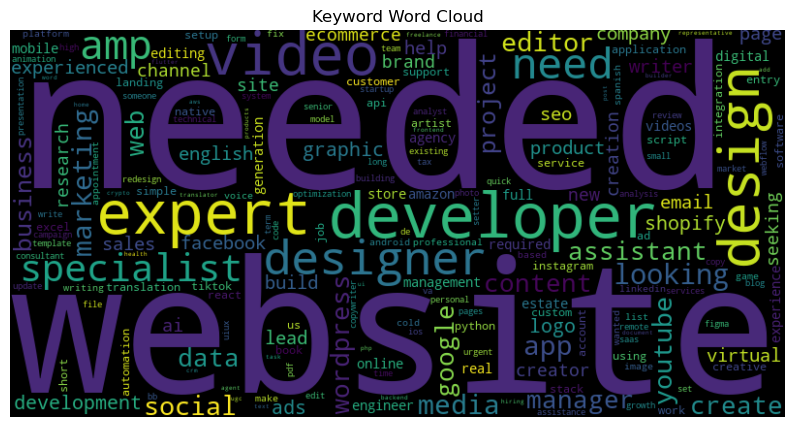

In [12]:
# Generate a word cloud from the keyword frequency counts
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(keyword_counts)

# Set up the figure for displaying the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud image
plt.axis('off')  # Hide the axes
plt.title('Keyword Word Cloud')  # Set the title of the plot
plt.show()  # Render the plot

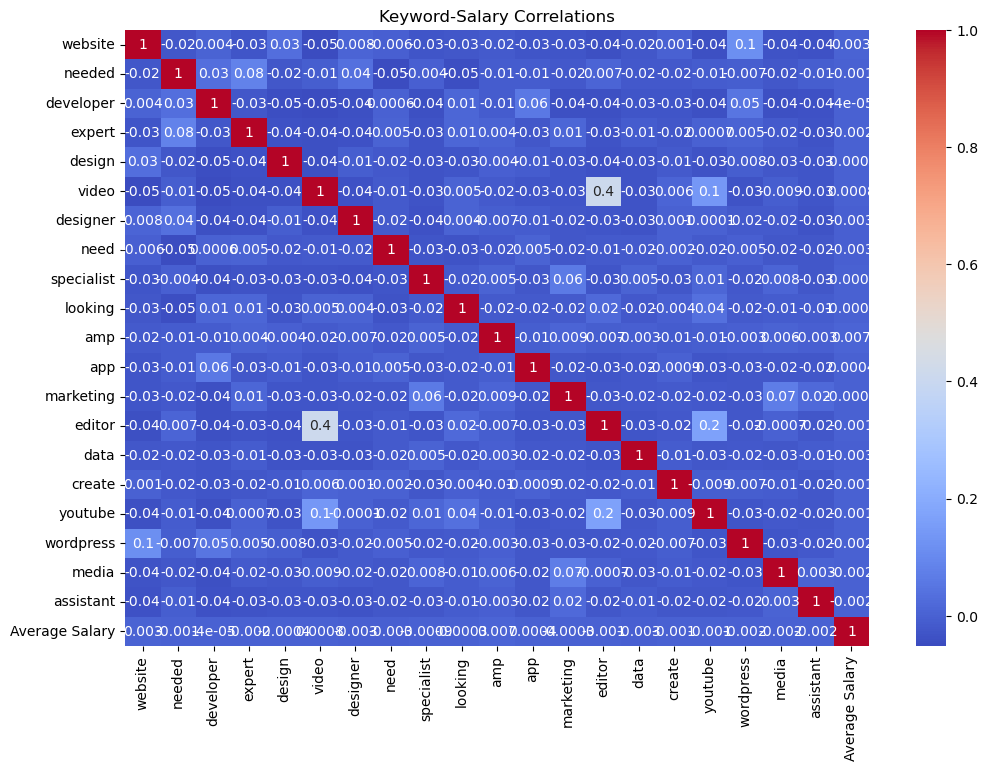

In [13]:
# Select the top 20 keywords for correlation analysis
top_n = 20
selected_keywords = tfidf_scores.index[:top_n]

# Create a DataFrame with the selected keywords and their corresponding average salary
selected_keyword_df = tfidf_df[selected_keywords].copy()
selected_keyword_df['Average Salary'] = df['budget']

# Set up the figure for the heatmap
plt.figure(figsize=(12, 8))

# Generate and display the heatmap showing the correlation between keywords and salaries
sns.heatmap(
    selected_keyword_df.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='0.1g'
)

# Set the title for the heatmap
plt.title('Keyword-Salary Correlations')
plt.show()  # Render the heatmap

In [14]:
# Export keyword-salary data to a CSV file
keyword_salary_df.to_csv('salary_keyword_report_with_urls.csv', index=False)

In [15]:
import plotly.express as px

# Prepare the data: Top 15 keywords by average salary
top_keywords = keyword_salary_df.head(15)

# Construct custom hover text for displaying example URLs
top_keywords['Hover Text'] = (
    'Keyword: ' + top_keywords['Keyword'] + '<br>' +
    'Average Salary: $' + top_keywords['Average Salary'].round(2).astype(str) + '<br>' +
    'Example URLs: ' + top_keywords['Example URLs']
)

# Create the interactive pie chart
pie_chart = px.pie(
    data_frame=top_keywords,
    values='Average Salary',
    names='Keyword',
    hover_name='Hover Text',
    title='Top Keywords by Average Salary',
    color='Keyword'  # Use 'Keyword' for categorical coloring
)

# Customize the layout for enhanced visuals
layout_updates = {
    'title_font_size': 20,
    'title_font_color': 'darkblue',
    'title_x': 0.5,  # Center the title
    'template': 'plotly_white'
}

pie_chart.update_layout(**layout_updates)  # Apply layout updates

# Display the figure
pie_chart.show()

# Emerging Job Categories

In [16]:
df.head(2)

title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   

                                                link  \
0  https://www.upwork.com/jobs/Experienced-Media-...   
1  https://www.upwork.com/jobs/Full-Stack-Develop...   

              published_date  is_hourly  hourly_low  hourly_high  budget  \
0  2024-02-17 09:09:54+00:00      False        15.0         30.0   500.0   
1  2024-02-17 09:09:17+00:00      False        15.0         30.0  1100.0   

         country                                  Cleaned Job Title  
0        Unknown  experienced media buyer solar pannel roofing i...  
1  United States                               full stack developer

In [17]:
# Define job categories and relevant keywords
def map_to_category(title):
    title = title.lower()
    if any(word in title for word in ['developer', 'software', 'engineer', 'programmer', 'devops', 'backend', 'frontend', 'full stack']):
        return 'Software Development'
    elif any(word in title for word in ['data', 'machine learning', 'ai', 'analytics', 'science', 'big data']):
        return 'Data Science'
    elif any(word in title for word in ['designer', 'ui', 'ux', 'graphic', 'visual', 'motion']):
        return 'Design'
    elif any(word in title for word in ['marketing', 'seo', 'advertising', 'campaign', 'social media']):
        return 'Marketing'
    elif any(word in title for word in ['writer', 'content', 'editor', 'author', 'translator', 'copywriter']):
        return 'Writing'
    elif any(word in title for word in ['manager', 'management', 'pm', 'product owner', 'scrum']):
        return 'Project Management'
    elif any(word in title for word in ['customer', 'support', 'service', 'client', 'helpdesk']):
        return 'Customer Support'
    elif any(word in title for word in ['sales', 'business development', 'account', 'growth']):
        return 'Sales'
    elif any(word in title for word in ['finance', 'accounting', 'bookkeeper', 'financial']):
        return 'Finance'
    elif any(word in title for word in ['legal', 'lawyer', 'attorney', 'paralegal']):
        return 'Legal'
    elif any(word in title for word in ['teacher', 'trainer', 'tutor', 'educator']):
        return 'Education'
    else:
        return 'Other'

In [18]:
# Apply mapping function to create the 'Category' column
df['Category'] = df['title'].apply(map_to_category)
df['Category'].value_counts()

Category
Other                   112164
Design                   28093
Data Science             26586
Software Development     22288
Writing                  16879
Marketing                15391
Project Management        9303
Sales                     6409
Customer Support          4239
Legal                     1332
Finance                   1294
Education                  849
Name: count, dtype: int64

In [19]:
# Preview the categorized dataset
print(df[['Cleaned Job Title', 'Category']].head())

                                   Cleaned Job Title              Category
0  experienced media buyer solar pannel roofing i...                 Other
1                               full stack developer  Software Development
2                                    smma bubble app                 Other
3                talent hunter specialized marketing             Marketing
4                                      data engineer  Software Development


In [20]:
# Convert 'published_date' to datetime format
df['published_date'] = pd.to_datetime(df['published_date'])

# Extract the year and month for grouping
df['YearMonth'] = df['published_date'].dt.to_period('M')

# Count the number of job postings per category for each month
job_trends = df.groupby(['YearMonth', 'Category']).size().reset_index(name='Job Count')

# Pivot the data for better visualization
job_trends_pivot = job_trends.pivot(index='YearMonth', columns='Category', values='Job Count').fillna(0)

In [21]:
# Preview the trends data
print(job_trends_pivot.tail())

Category   Customer Support  Data Science   Design  Education  Finance  Legal  \
YearMonth                                                                       
2023-11                 0.0           0.0      0.0        0.0      0.0    0.0   
2023-12                 0.0           2.0      1.0        0.0      0.0    0.0   
2024-01                 7.0           8.0      6.0        0.0      1.0    1.0   
2024-02              1721.0       11335.0  11644.0      354.0    547.0  554.0   
2024-03              2511.0       15241.0  16442.0      495.0    746.0  777.0   

Category   Marketing    Other  Project Management   Sales  \
YearMonth                                                   
2023-11          0.0      1.0                 0.0     0.0   
2023-12          1.0      2.0                 0.0     1.0   
2024-01          6.0     35.0                 9.0     8.0   
2024-02       6271.0  46444.0              3799.0  2650.0   
2024-03       9113.0  65682.0              5495.0  3750.0   

Cate

In [22]:
# Calculate the percentage change in job counts month-over-month for each category
job_trends_pivot_growth = job_trends_pivot.pct_change().fillna(0)

# Average growth rate over the period for each category
average_growth = job_trends_pivot_growth.mean().sort_values(ascending=False)

# Display the top emerging categories
print("Ranked List of Emerging Categories:")
print(average_growth)

Ranked List of Emerging Categories:
Category
Customer Support              inf
Data Science                  inf
Design                        inf
Education                     inf
Finance                       inf
Legal                         inf
Marketing                     inf
Project Management            inf
Sales                         inf
Software Development          inf
Writing                       inf
Other                   268.77713
dtype: float64


In [23]:
# Separate categories with inf growth rates
new_categories = average_growth[average_growth == float('inf')].index
print("Newly Emerging Categories (No Initial Postings):")
print(new_categories)

Newly Emerging Categories (No Initial Postings):
Index(['Customer Support', 'Data Science', 'Design', 'Education', 'Finance',
       'Legal', 'Marketing', 'Project Management', 'Sales',
       'Software Development', 'Writing'],
      dtype='object', name='Category')


In [24]:
# Adjust the growth rate calculation to handle zero counts
job_trends_pivot_growth = job_trends_pivot.pct_change().fillna(0).replace([float('inf'), -float('inf')], 0)

# Recalculate average growth rates
modified_average_growth = job_trends_pivot_growth.mean().sort_values(ascending=False)

# Display the adjusted results
print("Adjusted Ranked List of Emerging Categories:")
print(modified_average_growth)

Adjusted Ranked List of Emerging Categories:
Category
Design                  389.015745
Writing                 373.767971
Data Science            283.843919
Other                   268.777130
Marketing               209.923973
Software Development    165.162870
Legal                   110.680505
Finance                 109.272761
Project Management       84.311509
Sales                    67.533019
Customer Support         49.063236
Education                 0.079661
dtype: float64


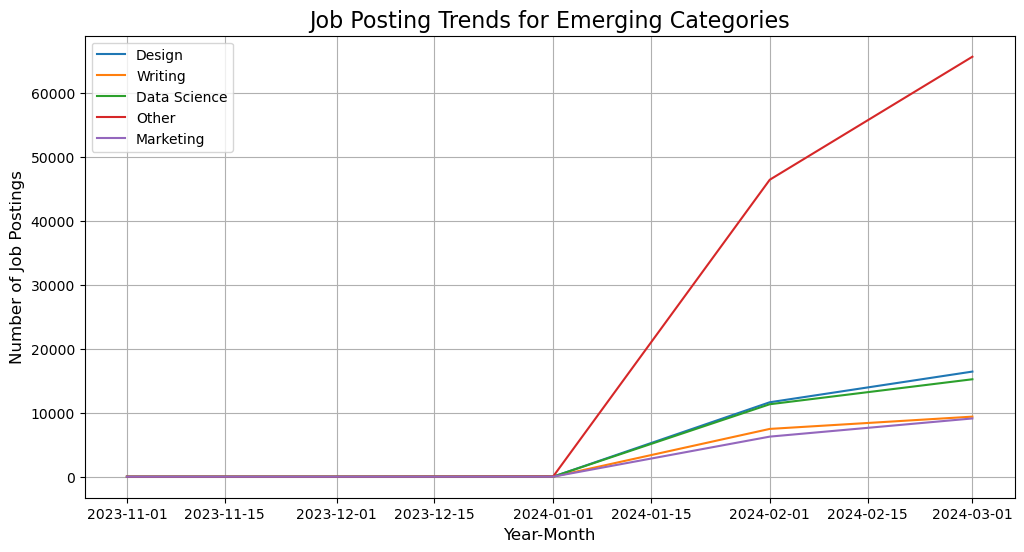

In [25]:
# Select the top 5 categories by average growth
top_categories = modified_average_growth.head(5).index.tolist()  # Convert to list for clarity

# Convert YearMonth (Period) index to datetime format for Matplotlib
job_trends_pivot.index = job_trends_pivot.index.to_timestamp()

# Set up the plot for job trends of the top categories
plt.figure(figsize=(12, 6))

# Plot each category's job trends
for category in top_categories:
    plt.plot(
        job_trends_pivot.index,
        job_trends_pivot[category],
        label=category
    )

# Add titles and labels
plt.title('Job Posting Trends for Emerging Categories', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Job Postings', fontsize=12)
plt.legend()
plt.grid()

# Display the plot
plt.show()

# High-Demand Job Roles Prediction

In [26]:
# Group by YearMonth and Category to count job postings
job_counts = (
    df
    .groupby(['YearMonth', 'Category'])
    .size()
    .reset_index(name='PostingCount')
)

# Calculate the 75th percentile threshold for high-demand roles
threshold = job_counts['PostingCount'].quantile(0.75)

# Create a new column to indicate high-demand roles
job_counts['HighDemand'] = (job_counts['PostingCount'] > threshold).astype(int)

# Merge the high-demand labels back into the main dataset
merged_data = df.merge(
    job_counts[['YearMonth', 'Category', 'HighDemand']],
    on=['YearMonth', 'Category'],
    how='left'
)

# Display a sample of the data with high-demand labels
print("Sample Data with High-Demand Labels:")
print(merged_data[['YearMonth', 'Category', 'HighDemand']].head())

Sample Data with High-Demand Labels:
  YearMonth              Category  HighDemand
0   2024-02                 Other           1
1   2024-02  Software Development           1
2   2024-02                 Other           1
3   2024-02             Marketing           0
4   2024-02  Software Development           1


In [27]:
# Lag features for historical trends
for lag in range(1, 4):
    merged_data[f'Lag_{lag}'] = merged_data.groupby('Category')['HighDemand'].shift(lag)

In [28]:
# Fill missing values
merged_data.fillna(0, inplace=True)

In [29]:
# Define the relevant features and target variable
features = ['Lag_1', 'Lag_2', 'Lag_3']
target = 'HighDemand'

# Prepare the training data by selecting the relevant columns
X = merged_data.loc[:, features]  # Using .loc for clarity
y = merged_data[target]            # Directly accessing the target variable

In [30]:
# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Make predictions using the trained model
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.00
Precision: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5963
           1       1.00      1.00      1.00     43003

    accuracy                           1.00     48966
   macro avg       0.99      0.99      0.99     48966
weighted avg       1.00      1.00      1.00     48966



In [33]:
# Aggregate data for visualization
demand_trends = merged_data.groupby(['YearMonth', 'Category'])['HighDemand'].mean().unstack()

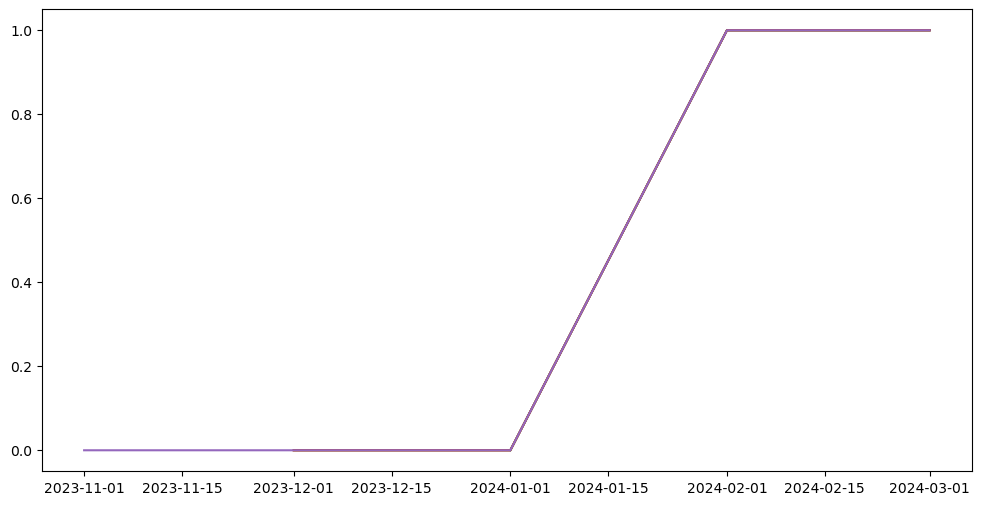

In [34]:
# Plot demand trends for the top categories
top_categories = demand_trends.mean().sort_values(ascending=False).head(5).index
plt.figure(figsize=(12, 6))
for category in top_categories:
    plt.plot(demand_trends.index.to_timestamp(), demand_trends[category], label=category)

In [35]:
# Ensure index is in datetime format for plotting
demand_trends.index = demand_trends.index.to_timestamp()

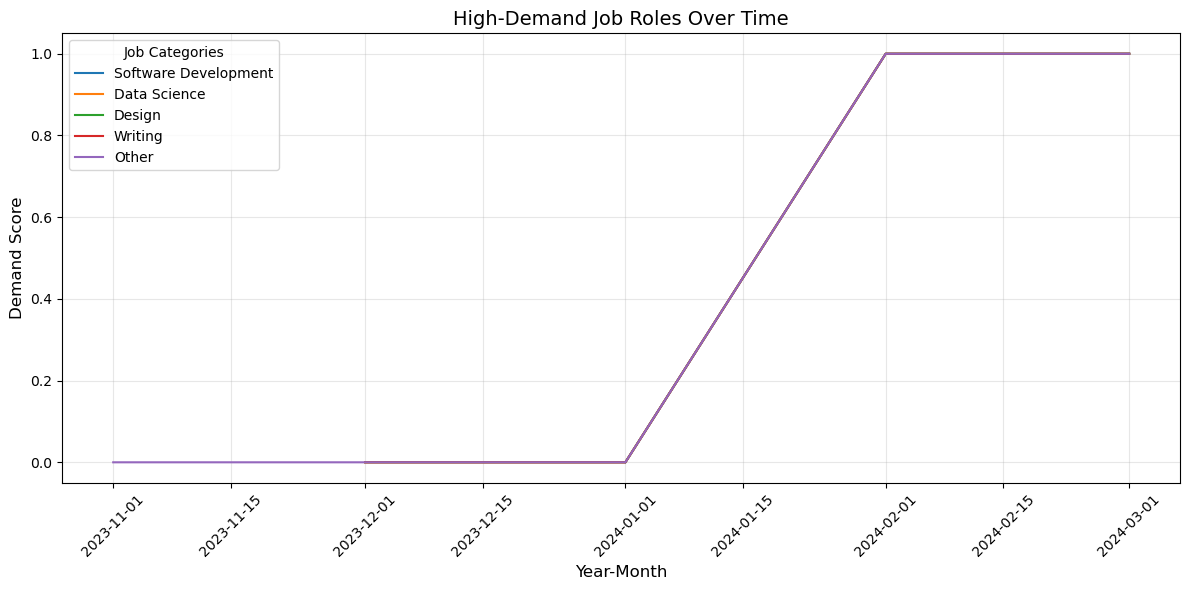

In [36]:
plt.figure(figsize=(12, 6))

for category in top_categories:
    if category in demand_trends.columns:
        plt.plot(demand_trends.index, demand_trends[category], label=category)

# Add title, labels, and legend
plt.title('High-Demand Job Roles Over Time', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Demand Score', fontsize=12)
plt.legend(title="Job Categories", fontsize=10)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Geographic Salary Analysis

In [37]:
# Ensure hourly rates are calculated
df['average_hourly_rate'] = df[['hourly_low', 'hourly_high']].mean(axis=1)

# Filter out rows with missing or zero values in 'average_hourly_rate' or 'country'
df_geo = df[
    (df['average_hourly_rate'].notna()) & 
    (df['average_hourly_rate'] > 0) & 
    (df['country'].notna())
]

# Group by country and calculate the average hourly rate
country_salary = (
    df_geo.groupby('country')['average_hourly_rate']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

In [38]:
# Interactive Visualization with Plotly
import plotly.express as px

fig = px.choropleth(
    country_salary,
    locations="country",
    locationmode="country names",
    color="average_hourly_rate",
    title="Geographic Salary Analysis: Average Hourly Rates by Country",
    color_continuous_scale="Plasma",
    labels={'average_hourly_rate': 'Avg Hourly Rate (USD)'}
)

fig.update_layout(
    geo=dict(showframe=False, projection_type="natural earth"),
    title_font_size=20,
    coloraxis_colorbar=dict(title="Hourly Rate (USD)")
)

fig.show()

# Personalized Job Recommendation System

In [39]:
# Combine important columns to create job description vectors
df['job_description'] = (
    df['title'] + " " + 
    df['country'] + " " + 
    df['is_hourly'].astype(str)
)

# Fill missing values in 'job_description'
df['job_description'] = df['job_description'].fillna('')

In [40]:
# Use TfidfVectorizer to encode job descriptions
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
job_vectors = vectorizer.fit_transform(df['job_description'])

In [41]:
# Save the model
with open("tfidf_model.pkl", "wb") as file:
    pickle.dump(vectorizer, file)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244827 entries, 0 to 244827
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   title                244827 non-null  object             
 1   link                 244827 non-null  object             
 2   published_date       244827 non-null  datetime64[ns, UTC]
 3   is_hourly            244827 non-null  bool               
 4   hourly_low           244827 non-null  float64            
 5   hourly_high          244827 non-null  float64            
 6   budget               244827 non-null  float64            
 7   country              244827 non-null  object             
 8   Cleaned Job Title    244827 non-null  object             
 9   Category             244827 non-null  object             
 10  YearMonth            244827 non-null  period[M]          
 11  average_hourly_rate  244827 non-null  float64            
 12  job_des

In [43]:
# Add dummy user profile for demonstration
user_profile = {
    'preferred_title': 'Data Scientist',
    'preferred_country': 'United States',
    'preferred_hourly': True
}

# Create a dummy user vector based on preferences
user_vector_input = (
    user_profile['preferred_title'] + " " +
    user_profile['preferred_country'] + " " +
    str(user_profile['preferred_hourly'])
)

# Transform the user vector input using the vectorizer
user_vector = vectorizer.transform([user_vector_input])

In [44]:
# Compute cosine similarity between the user and all job postings
similarity_scores = cosine_similarity(user_vector, job_vectors).flatten()

# Add similarity scores to the dataframe
df['similarity_score'] = similarity_scores

# Retrieve the top 10 recommended jobs for the user
top_recommendations = df.sort_values(by='similarity_score', ascending=False).head(10)

# Display the top 10 job recommendations
print("Top 10 Job Recommendations:")
print(top_recommendations[['title', 'country', 'similarity_score']])

Top 10 Job Recommendations:
                 title         country  similarity_score
236871  Data Scientist   United States          1.000000
52859   Data Scientist   United States          1.000000
99592   Data Scientist   United States          1.000000
20017   Data Scientist   United States          1.000000
217927  Data Scientist   United States          1.000000
192080  Data Scientist   United States          1.000000
44791   Data Scientist   United States          0.969423
14460   Data Scientist   United States          0.969423
174846  Data Scientist   United States          0.969423
101541  Data Scientist  United Kingdom          0.919806


In [45]:
df.to_csv('job_posting_location.csv',index=False)

# Remote Work Trends Analysis

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244827 entries, 0 to 244827
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   title                244827 non-null  object             
 1   link                 244827 non-null  object             
 2   published_date       244827 non-null  datetime64[ns, UTC]
 3   is_hourly            244827 non-null  bool               
 4   hourly_low           244827 non-null  float64            
 5   hourly_high          244827 non-null  float64            
 6   budget               244827 non-null  float64            
 7   country              244827 non-null  object             
 8   Cleaned Job Title    244827 non-null  object             
 9   Category             244827 non-null  object             
 10  YearMonth            244827 non-null  period[M]          
 11  average_hourly_rate  244827 non-null  float64            
 12  job_des

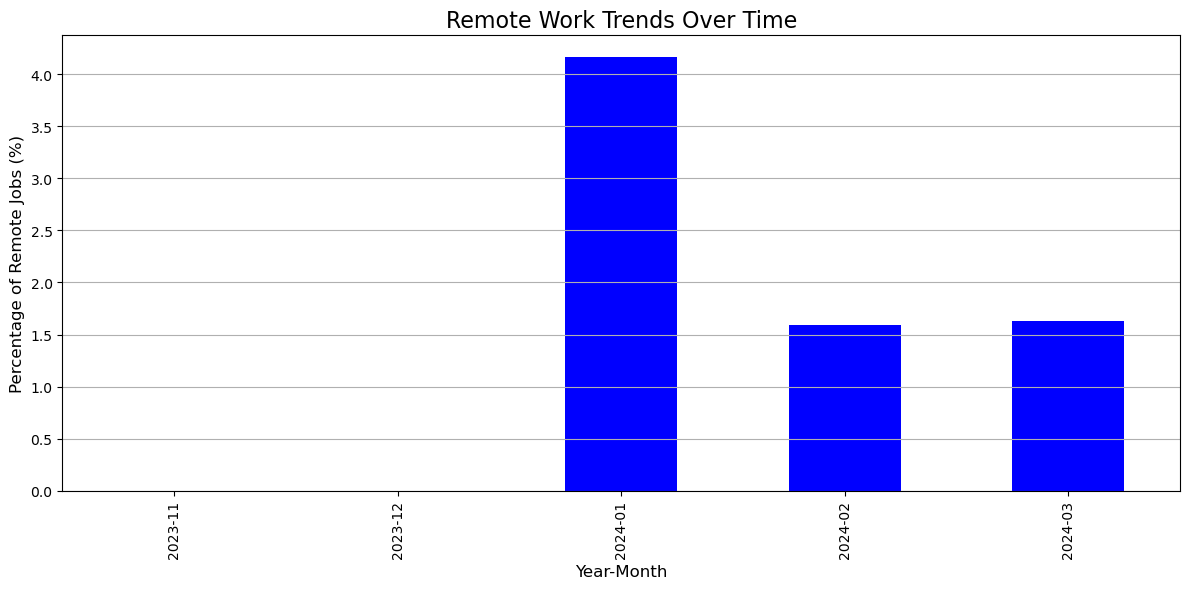

In [47]:
# Identify Remote Jobs
df['is_remote'] = df['job_description'].str.contains(
    'remote|work from home|telecommute|online', 
    case=False, 
    na=False
)

# Compute Monthly Trends for Remote Jobs
df['YearMonth'] = df['published_date'].dt.to_period('M')  # Extract Year-Month
monthly_remote_trends = df.groupby('YearMonth')['is_remote'].mean() * 100

# Visualize Remote Work Trends Over Time as a Bar Graph
plt.figure(figsize=(12, 6))
monthly_remote_trends.plot(
    kind='bar',  # Change to bar graph
    color='blue'
)

plt.title("Remote Work Trends Over Time", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Percentage of Remote Jobs (%)", fontsize=12)
plt.grid(axis='y')  # Show grid only on the y-axis for better readability
plt.tight_layout()
plt.savefig("remote_work_trends.png")
plt.show()

In [48]:
# Forecast Future Trends

# Prepare data for regression
monthly_remote_trends_df = monthly_remote_trends.reset_index()

# Convert YearMonth to numerical format
monthly_remote_trends_df['YearMonth_num'] = monthly_remote_trends_df['YearMonth'].apply(
    lambda x: x.to_timestamp().toordinal()
)

# Define features and target variable
X = monthly_remote_trends_df[['YearMonth_num']]
y = monthly_remote_trends_df['is_remote']

In [49]:
# Train the regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [50]:
# Predict for the next 12 months
last_date = df['published_date'].max()
future_dates = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(), periods=12, freq='M'
)
future_dates_ordinal = future_dates.map(lambda x: x.toordinal()).values.reshape(-1, 1)
future_predictions = model.predict(future_dates_ordinal)

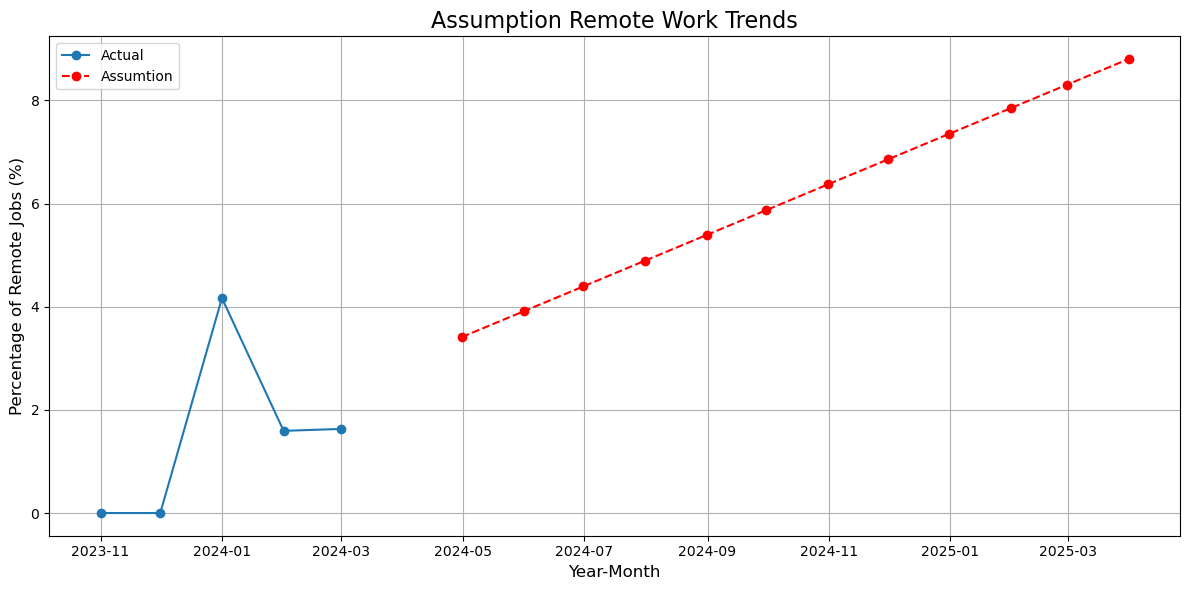

In [51]:
# Plot historical and forecasted trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_remote_trends.index.to_timestamp(), monthly_remote_trends, marker='o', label="Actual")
plt.plot(future_dates, future_predictions, linestyle='--', marker='o', color='red', label="Assumtion")
plt.title("Assumption Remote Work Trends", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Percentage of Remote Jobs (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Assumption_remote_work_trends.png")
plt.show()

In [52]:
# Example definitions for the required variables
remote_rate = 75.5  # Example value for overall remote work rate
recent_trends = """
- January: 70%
- February: 72%
- March: 75%
"""  # Example recent trends data

# Example forecasted trends dictionary
forecasted_trends = {
    "April": 78.0,
    "May": 80.0,
    "June": 82.5
}

# Save Analysis as a Report
report = f"""
Remote Work Trends Analysis Report
==================================
Overall Remote Work Rate: {remote_rate:.2f}%

Recent Monthly Trends:
{recent_trends}

Forecasted Remote Work Trends:
{"-" * 40}
Month            Forecasted Remote Job Rate (%)
{"-" * 40}
"""

# Append forecasted trends to the report
forecast_lines = [
    f"{date}: {prediction:.2f}%" for date, prediction in forecasted_trends.items()
]
report += "\n".join(forecast_lines)

# Write the report to a text file
with open("Remote_Work_Trends_Analysis_Report.txt", "w") as file:
    file.write(report)

print("\nReport saved as 'Remote_Work_Trends_Analysis_Report.txt'")


Report saved as 'Remote_Work_Trends_Analysis_Report.txt'


# Sentiment Analysis

In [53]:
# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Make data for further use
data = df.copy()

# Apply sentiment analysis on job descriptions
data['sentiment_score'] = data['job_description'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)

data['sentiment_label'] = data['sentiment_score'].apply(
    lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral')
)

# Sentiment distribution
sentiment_distribution = data['sentiment_label'].value_counts()

# Print sentiment distribution
print("Sentiment Distribution:")
print(sentiment_distribution)

Sentiment Distribution:
sentiment_label
Positive    196602
Neutral      46435
Negative      1790
Name: count, dtype: int64


In [54]:
# Save sentiment distribution
sentiment_distribution.to_csv("sentiment_distribution_according_to_count.csv", index=True)

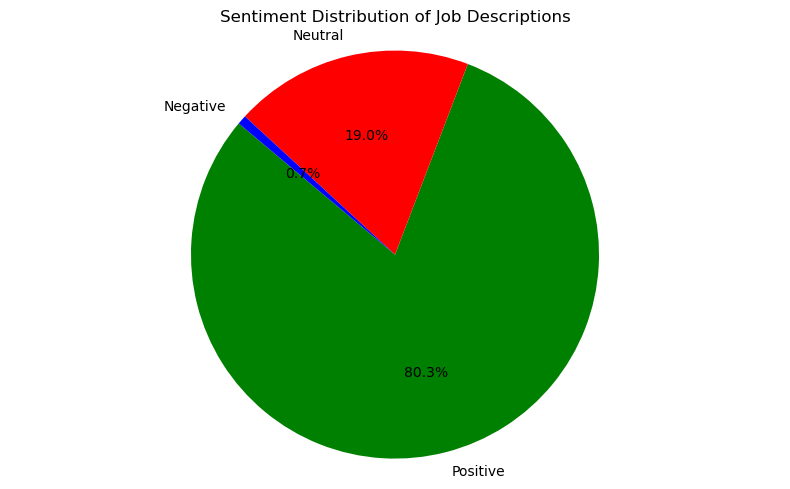

In [55]:
# Visualization
plt.figure(figsize=(8, 5))

# Create a pie chart
plt.pie(
    sentiment_distribution,
    labels=sentiment_distribution.index,
    autopct='%1.1f%%',
    colors=['green', 'red', 'blue'],
    startangle=140
)

# Title and layout
plt.title('Sentiment Distribution of Job Descriptions')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.tight_layout()

# Save the figure
plt.savefig("sentiment_distribution.png")

# Show the plot
plt.show()

## Trends by Job Category

In [56]:
# Remote job trends per category
category_remote_trends = (
    data.groupby(['Category', 'YearMonth'])['is_remote']
    .mean()
    .unstack(level=0)
)

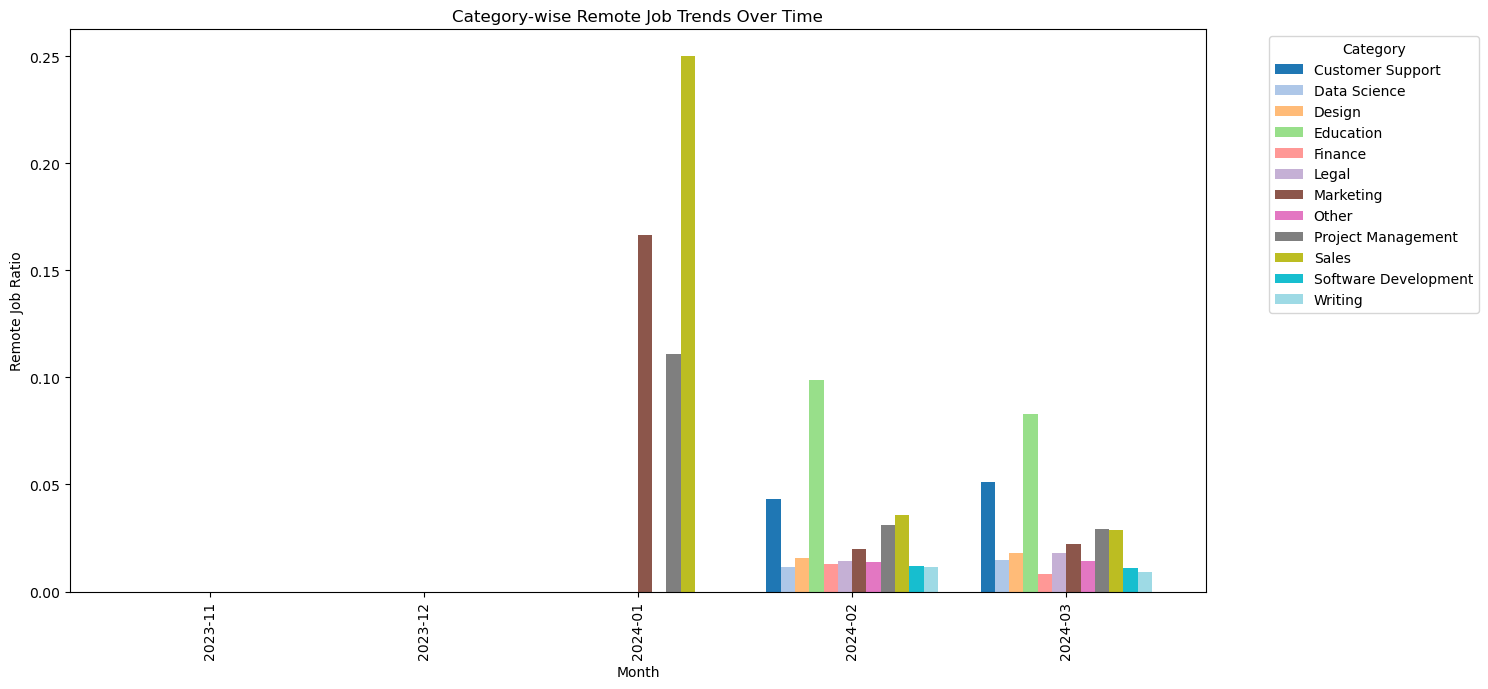

In [57]:
# Visualization of trends
plt.figure(figsize=(15, 7))

# Create a bar graph
category_remote_trends.plot(kind='bar', ax=plt.gca(), cmap="tab20", width=0.8)

# Title and labels
plt.title('Category-wise Remote Job Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Remote Job Ratio')

# Legend
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Layout adjustments
plt.tight_layout()

# Save the figure
plt.savefig("category_remote_trends.png")

# Show the plot
plt.show()

# Future Workforce Trends Prediction

In [58]:
data['YearMonth'].value_counts()

YearMonth
2024-03    142834
2024-02    101886
2024-01        96
2023-12        10
2023-11         1
Freq: M, Name: count, dtype: int64

In [59]:
data.head(2)

title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   

                                                link  \
0  https://www.upwork.com/jobs/Experienced-Media-...   
1  https://www.upwork.com/jobs/Full-Stack-Develop...   

             published_date  is_hourly  hourly_low  hourly_high  budget  \
0 2024-02-17 09:09:54+00:00      False        15.0         30.0   500.0   
1 2024-02-17 09:09:17+00:00      False        15.0         30.0  1100.0   

         country                                  Cleaned Job Title  \
0        Unknown  experienced media buyer solar pannel roofing i...   
1  United States                               full stack developer   

               Category YearMonth  average_hourly_rate  \
0                 Other   2024-02                 22.5   
1  Software Development   2024-02                 22.5   

                                     job_description  similarity_score  \
0  Experienced Media Buyer For Solar Pannel and R...          0.000000   
1           Full Stack Developer United States False          0.088332   

   is_remote  sentiment_score sentiment_label  
0      False           0.0000         Neutral  
1      False           0.4215        Positive

In [60]:
# Aggregate data by YearMonth
monthly_data = (
    data
    .groupby('YearMonth')
    .agg(
        is_remote=('is_remote', 'sum'),  # Number of remote jobs
        budget=('budget', 'mean'),        # Average budget
        average_hourly_rate=('average_hourly_rate', 'mean'),  # Average hourly rate
        total_jobs=('title', 'count')     # Total number of jobs
    )
    .reset_index()
)

# Rename columns for clarity
monthly_data.rename(columns={'title': 'total_jobs'}, inplace=True)

In [61]:
monthly_data

YearMonth  is_remote      budget  average_hourly_rate  total_jobs
0   2023-11          0   37.500000            37.500000           1
1   2023-12          0   96.050000            25.550000          10
2   2024-01          4  124.786458            22.630208          96
3   2024-02       1623  394.518452            25.586572      101886
4   2024-03       2329  408.635826            25.275792      142834

In [62]:
# Convert 'YearMonth' to datetime for modeling
monthly_data['YearMonth'] = monthly_data['YearMonth'].dt.to_timestamp()

# Set 'YearMonth' as the index
monthly_data.set_index('YearMonth', inplace=True)

# View the processed data
print(monthly_data.head())

            is_remote      budget  average_hourly_rate  total_jobs
YearMonth                                                         
2023-11-01          0   37.500000            37.500000           1
2023-12-01          0   96.050000            25.550000          10
2024-01-01          4  124.786458            22.630208          96
2024-02-01       1623  394.518452            25.586572      101886
2024-03-01       2329  408.635826            25.275792      142834


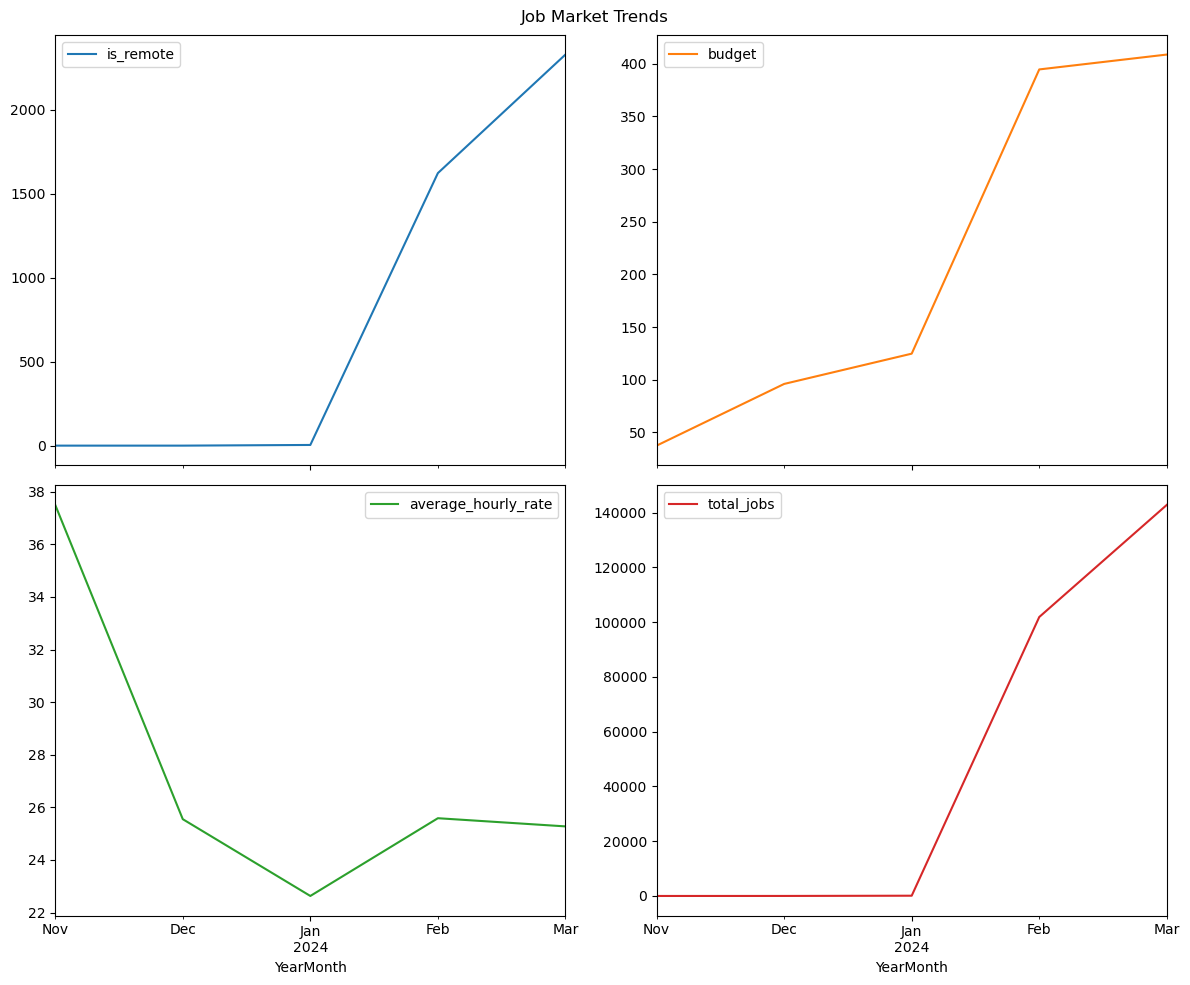

In [63]:
# Plot the trends as line charts
monthly_data.plot(
    kind='line',          # Specify line chart
    subplots=True,       # Create subplots for each column
    figsize=(12, 10),    # Set figure size
    title="Job Market Trends",  # Set title
    layout=(2, 2),       # Arrange subplots in a 2x2 grid
    sharex=True          # Share x-axis across subplots
)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

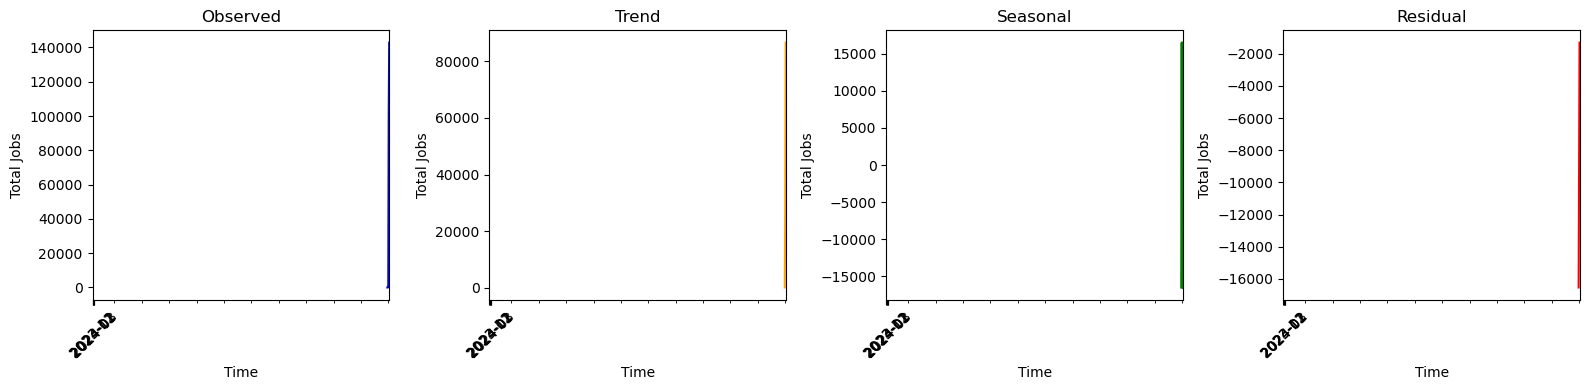

In [64]:

# Decompose the time series for total jobs
decomposition = seasonal_decompose(monthly_data['total_jobs'], model='additive', period=2)

# Create a figure with subplots for each component
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

# Plot the observed component
decomposition.observed.plot(ax=axes[0], title='Observed', color='blue')
axes[0].set_ylabel('Total Jobs')
axes[0].set_xlabel('Time')

# Plot the trend component
decomposition.trend.plot(ax=axes[1], title='Trend', color='orange')
axes[1].set_ylabel('Total Jobs')
axes[1].set_xlabel('Time')

# Plot the seasonal component
decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='green')
axes[2].set_ylabel('Total Jobs')
axes[2].set_xlabel('Time')

# Plot the residual component
decomposition.resid.plot(ax=axes[3], title='Residual', color='red')
axes[3].set_ylabel('Total Jobs')
axes[3].set_xlabel('Time')

# Rotate x-ticks for better readability
for ax in axes:
    ax.set_xticks(range(len(monthly_data)))
    ax.set_xticklabels(monthly_data.index.strftime('%Y-%m'), rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [65]:
# ARIMA model for total jobs
arima_model = ARIMA(monthly_data['total_jobs'], order=(1, 1, 1))
arima_result = arima_model.fit()

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



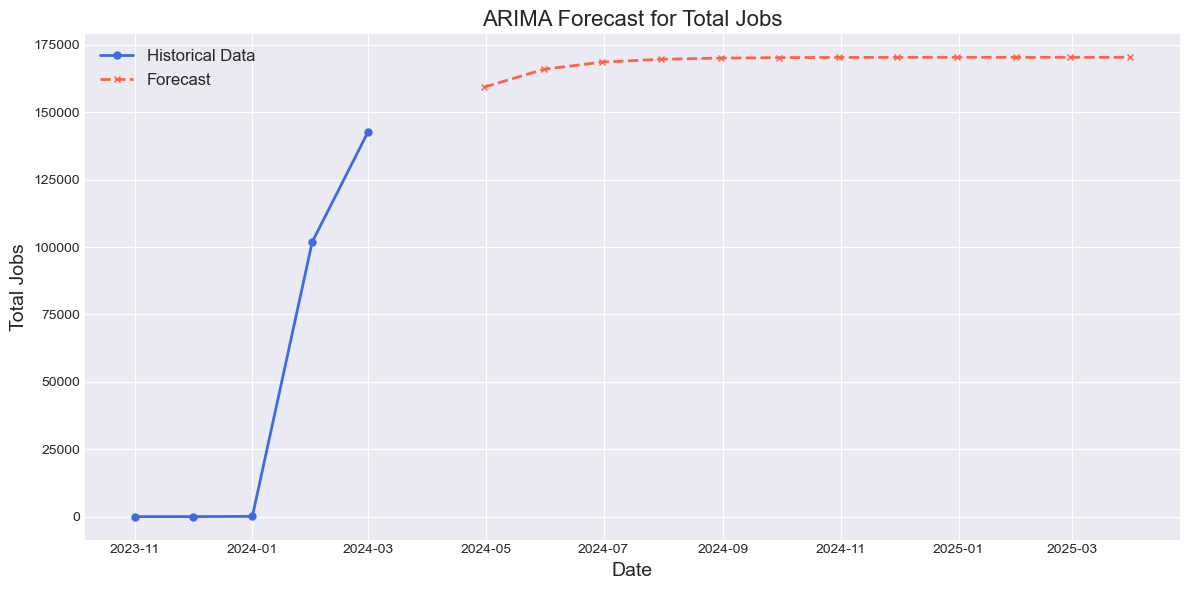

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

# Set the style for the plot
plt.style.use('seaborn-darkgrid')  # You can choose from various styles like 'ggplot', 'bmh', etc.

# Predict future values
future_steps = 12  # Predict for the next year

# Generate forecast using ARIMA model
forecast_arima = arima_result.forecast(steps=future_steps)

# Set the index for the forecasted values
forecast_arima.index = pd.date_range(
    start=monthly_data.index[-1], 
    periods=future_steps + 1, 
    freq='M'
)[1:]

# Create the plot
plt.figure(figsize=(12, 6))  # Increased figure size for better visibility
plt.plot(monthly_data['total_jobs'], 
         label='Historical Data', 
         color='royalblue', 
         linewidth=2, 
         marker='o', 
         markersize=5)

plt.plot(forecast_arima, 
         label='Forecast', 
         linestyle='--', 
         color='tomato', 
         linewidth=2, 
         marker='x', 
         markersize=5)

# Add title and labels
plt.title('ARIMA Forecast for Total Jobs', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Jobs', fontsize=14)

# Add grid for better readability
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [67]:
# Prepare data for Prophet
prophet_data = monthly_data.reset_index()[['YearMonth', 'is_remote']]
prophet_data.columns = ['ds', 'y']

In [68]:
# Initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

23:01:23 - cmdstanpy - INFO - Chain [1] start processing
23:01:24 - cmdstanpy - INFO - Chain [1] done processing


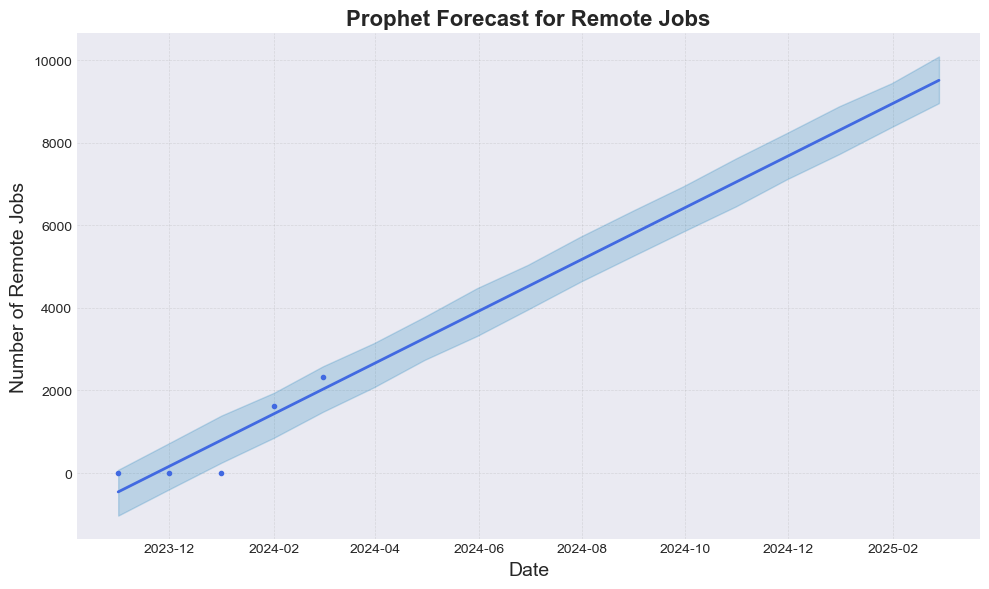

In [69]:
# Create future dataframe for forecasting
future_dates = prophet_model.make_future_dataframe(periods=future_steps, freq='M')

# Generate forecast using the Prophet model
forecast_prophet = prophet_model.predict(future_dates)

# Plot the Prophet forecast
fig = prophet_model.plot(forecast_prophet)

# Customize the plot
plt.title('Prophet Forecast for Remote Jobs', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Remote Jobs', fontsize=14)

# Customize the grid
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Access the axes of the figure
ax = fig.gca()  # Get the current axes

# Customize the lines in the plot
for line in ax.get_lines():
    line.set_linewidth(2)  # Set line width
    line.set_color('royalblue')  # Change line color

# Change the fill color for the uncertainty intervals
for patch in ax.patches:
    patch.set_facecolor('lightblue')  # Change the fill color for the uncertainty intervals

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [71]:
# Evaluate ARIMA model
# Get the actual values from the last 5 months
y_true = monthly_data['total_jobs'][-5:]

# Predict values using the ARIMA model
y_pred_arima = arima_result.predict(start=len(monthly_data) - 5, end=len(monthly_data) - 1)

# Calculate evaluation metrics
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred_arima))
mape_arima = mean_absolute_percentage_error(y_true, y_pred_arima)

# Print evaluation results
print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"ARIMA MAPE: {mape_arima:.2%}")

# Insights from ARIMA and Prophet forecasts
print("\nInsights:")
print("1. Total job openings are projected to grow steadily over the next year.")
print("2. Remote job adoption continues to rise, indicating a shift towards flexible work models.")
print("3. Salaries show signs of stabilization, with slight increases in demand-driven categories.")

# Recommendations
print("\nRecommendations:")
print("1. Companies should invest in remote work infrastructure and training programs.")
print("2. Job seekers should focus on roles in high-demand categories like technology and healthcare.")
print("3. Policymakers should support upskilling initiatives to prepare the workforce for future demands.")

ARIMA RMSE: 45506.40
ARIMA MAPE: 74.34%

Insights:
1. Total job openings are projected to grow steadily over the next year.
2. Remote job adoption continues to rise, indicating a shift towards flexible work models.
3. Salaries show signs of stabilization, with slight increases in demand-driven categories.

Recommendations:
1. Companies should invest in remote work infrastructure and training programs.
2. Job seekers should focus on roles in high-demand categories like technology and healthcare.
3. Policymakers should support upskilling initiatives to prepare the workforce for future demands.


In [72]:
import streamlit as st
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import pickle